In [61]:
# Instalación de librerias
# !pip install pandas matplotlib seaborn scikit-learn datetime

In [62]:
# Importo las librerias a utilizar

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [63]:
# 1. Cargar los datos

# Primero, cargo los datos y realizo un análisis básico para entender su estructura.

In [64]:


df = pd.read_csv('Online_Retail.csv', encoding='ISO-8859-1')

print(df.head())

print(df.info())

print(df.describe(include='all'))

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

    InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/10 8:26       2.55     17850.0  United Kingdom  
1  12/1/10 8:26       3.39     17850.0  United Kingdom  
2  12/1/10 8:26       2.75     17850.0  United Kingdom  
3  12/1/10 8:26       3.39     17850.0  United Kingdom  
4  12/1/10 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-

In [65]:
# 2. Limpieza de datos
# limpio los datos, manejo los valores faltantes y corrijo los tipos de datos.

In [66]:
# Eliminar filas en las que el CustomerID es nulo

df = df.dropna(subset=['CustomerID'])

# Eliminar filas con 'c' en InvoiceNo (cancelaciones)
df = df[~df['InvoiceNo'].str.startswith('C')]

# Convertir InvoiceDate a datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%y %H:%M')

# Convertir Quantity y UnitPrice a numérico (aunque ya deben ser numéricos)
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors='coerce')

# Crear una nueva columna para el precio total
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [67]:
# 3. Análisis de datos exploratorios

# Realizar un análisis básico para entender las ventas, la distribución de productos, etc.

Country
United Kingdom          7308391.554
Netherlands              285446.340
EIRE                     265545.900
Germany                  228867.140
France                   209024.050
Australia                138521.310
Spain                     61577.110
Switzerland               56443.950
Belgium                   41196.340
Sweden                    38378.330
Japan                     37416.370
Norway                    36165.440
Portugal                  33439.890
Finland                   22546.080
Singapore                 21279.290
Channel Islands           20450.440
Denmark                   18955.340
Italy                     17483.240
Cyprus                    13590.380
Austria                   10198.680
Poland                     7334.650
Israel                     7221.690
Greece                     4760.520
Iceland                    4310.000
Canada                     3666.380
USA                        3580.390
Malta                      2725.590
Unspecified         

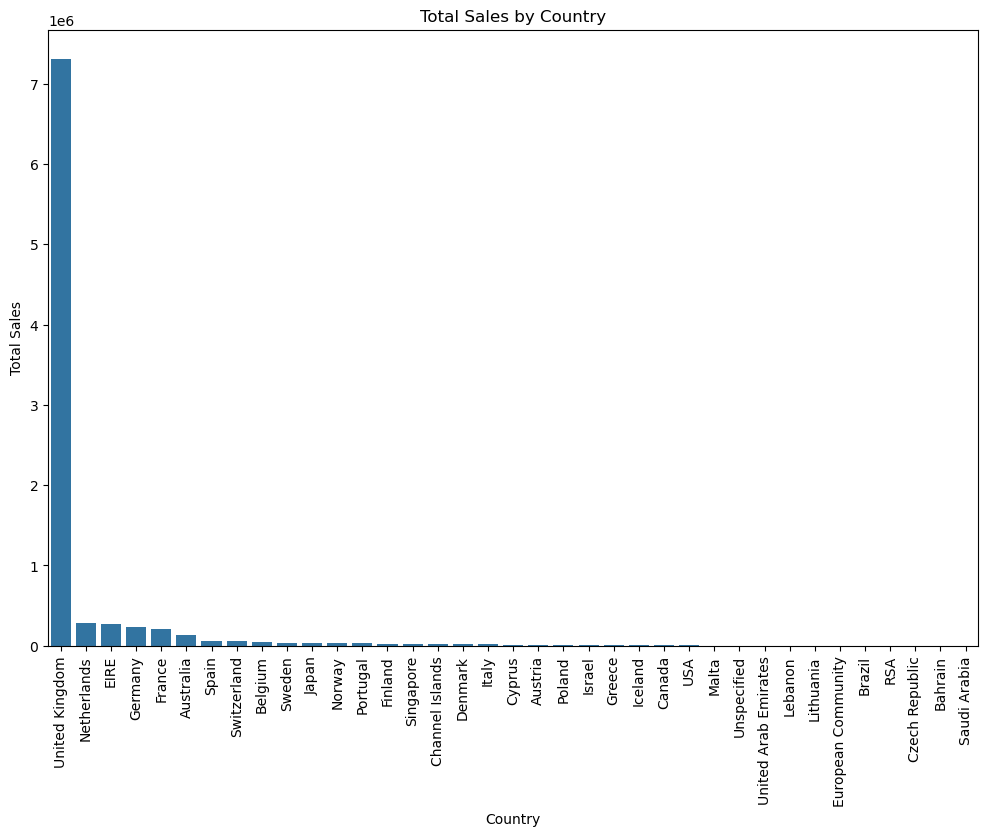

Description
PAPER CRAFT , LITTLE BIRDIE           168469.60
REGENCY CAKESTAND 3 TIER              142592.95
WHITE HANGING HEART T-LIGHT HOLDER    100448.15
JUMBO BAG RED RETROSPOT                85220.78
MEDIUM CERAMIC TOP STORAGE JAR         81416.73
POSTAGE                                77803.96
PARTY BUNTING                          68844.33
ASSORTED COLOUR BIRD ORNAMENT          56580.34
Manual                                 53779.93
RABBIT NIGHT LIGHT                     51346.20
Name: TotalPrice, dtype: float64


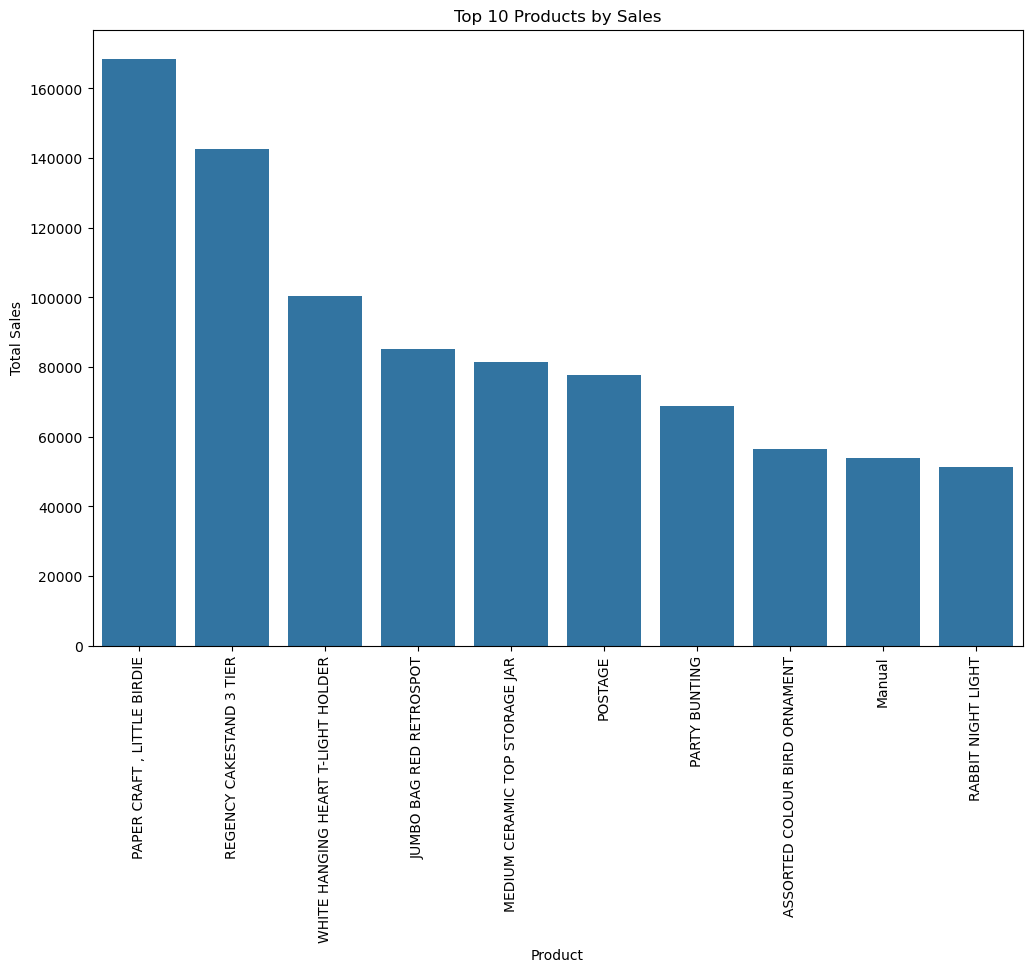

In [68]:


# Ventas por país
country_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
print(country_sales)

# Gráfico de ventas totales por países
plt.figure(figsize=(12, 8))
sns.barplot(x=country_sales.index, y=country_sales.values)
plt.xticks(rotation=90)
plt.title('Total Sales by Country')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.show()

# Gráfico de ventas totales por  producto
product_sales = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False)
print(product_sales.head(10))

# Gráfico de top 10 productos más vendidos
plt.figure(figsize=(12, 8))
sns.barplot(x=product_sales.head(10).index, y=product_sales.head(10).values)
plt.xticks(rotation=90)
plt.title('Top 10 Products by Sales')
plt.xlabel('Product')
plt.ylabel('Total Sales')
plt.show()


In [69]:
# 4. Análisis de RFM


In [70]:


# Establecer la fecha de referencia para el cálculo de la recencia
current_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)

# Calculo RFM
rfm_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'TotalPrice': 'sum'    # Monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
})

print(rfm_df.head())


            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2        182   4310.00
12348.0          75         31   1797.24
12349.0          19         73   1757.55
12350.0         310         17    334.40


In [71]:
# 5. Segmentación de clientes

# Realizo la segmentación de clientes usando clustering.

In [72]:

# Estandarizar los datos de RFM
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df)

# Realizar agrupación por K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Mostrar las primeras filas con clusters
print(rfm_df.head())

# Analizar cluzters
cluster_summary = rfm_df.groupby('Cluster').mean()
print(cluster_summary)


            Recency  Frequency  Monetary  Cluster
CustomerID                                       
12346.0         326          1  77183.60        3
12347.0           2        182   4310.00        0
12348.0          75         31   1797.24        1
12349.0          19         73   1757.55        0
12350.0         310         17    334.40        3
            Recency    Frequency       Monetary
Cluster                                        
0         20.886374   135.476212    2648.875746
1         97.846732    37.891811     777.692744
2          4.692308  2566.000000  126118.310000
3        272.196386    25.091566     604.752820


In [73]:
# 6. Visualizar grupos

# Ver los clústeres para comprender los segmentos de clientes.

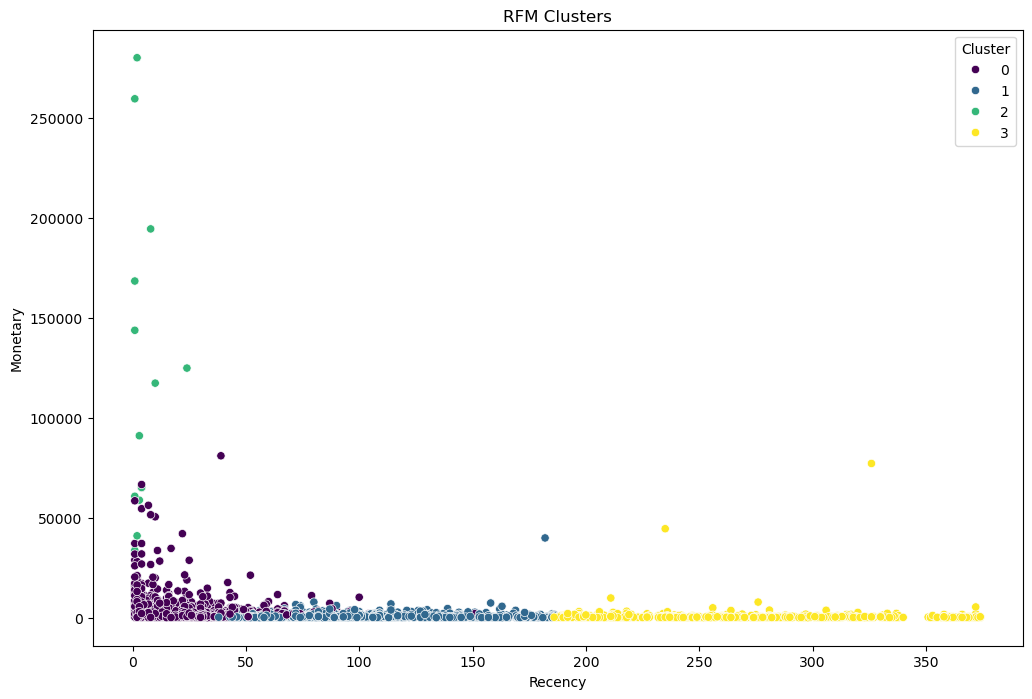

In [74]:
# Pairplot clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=rfm_df, x='Recency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('RFM Clusters')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()